## Project: Advanced Lane Finding 
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


Import Packages

In [51]:
#import usefule package
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

%matplotlib inline


### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


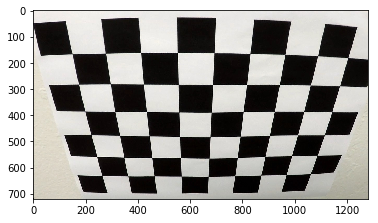

In [52]:
#get one image for basic shape information
#reading the image for test
img_chessboard =mpimg.imread('camera_cal/calibration2.jpg')
print('This image is:', type(img_chessboard), 'with dimensions:', img_chessboard.shape)
plt.imshow(img_chessboard)

In [53]:
# find the corners and get the objpoints and imgpoints for the chessboard.

def calGetPoints(img,nx=9, ny=6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    #objpoints = [] # 3d point in real world space
    #imgpoints = [] # 2d points in image plane.

    #conver to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #find the chessboard corners
    ret,corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print('find the corners:', ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
    return ret, objpoints, imgpoints

#calculate the undistortion 
def calUndistort(img, objpoints, imgpoints):        
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist,mtx,dist
# Plot the original image and the result image
def plotOrignalResult(img_original, img_result, result_cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(img_original)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(img_result, result_cmap)
    ax2.set_title('Result Image', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


def calAllUndistort():
    
    image_names = os.listdir("camera_cal/")
    
    for img_name in image_names:
        #read one img
        img_dir = "camera_cal/"+img_name        
        img =mpimg.imread(img_dir)
        #get the objpoints and imgpoints
        ret,objpoints,imgpoints = calGetPoints(img_chessboard,nx=9, ny=6)
        if ret == False:
            continue
        
        undistorted,mtx,dist = calUndistort(img, objpoints, imgpoints)
        
        #plot the original image and undistorted image
        #plotOrignalResult(img, undistorted)        
        #save the undistorted img
        #mpimg.imsave('output_images/'+img_name,undistorted)
        return mtx,dist
        
    
#test on img：
print('----Test-----')
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

#ret,objpoints,imgpoints = calGetPoints(img_chessboard,objpoints =None,imgpoints=None, nx=9, ny=6)
#undistorted, mtx, dist = calUndistort(img_chessboard, objpoints, imgpoints)
#plotOrignalResult(img_chessboard, undistorted)   

#output all undistort images
#print('undistort the all images:')
mtx,dist =calAllUndistort()
#print('objpoints,imgpoints:',objpoints,imgpoints)
print('mtx,dist:',mtx,dist)




----Test-----
mtx,dist: [[ 787.65375347    0.          646.9152222 ]
 [   0.          754.60606491  212.59260683]
 [   0.            0.            1.        ]] [[-0.1583542   0.0725229   0.02115715  0.0027917  -0.0061491 ]]


### 2. Apply a distortion correction to raw images.

apply a distortion correction to a raw images: 


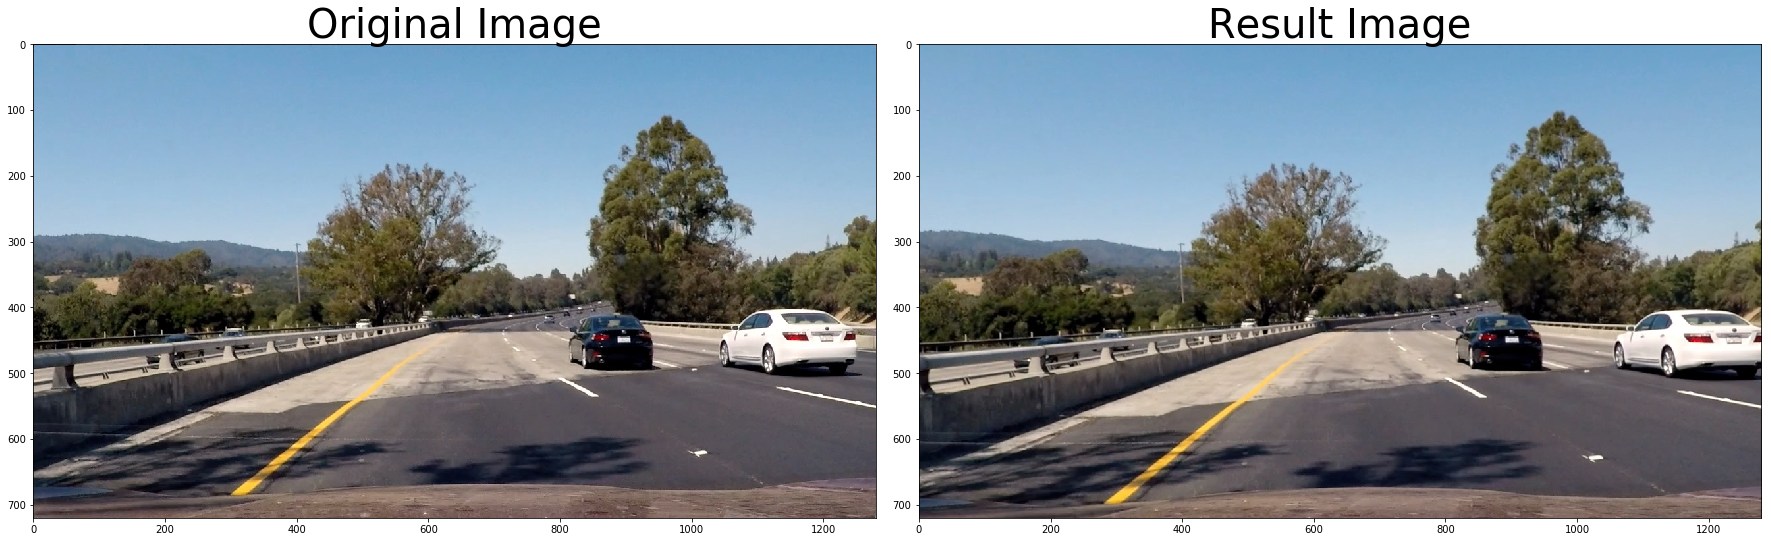

In [54]:
#get the mtx ,dist of a chessboard pattern
#print('read the test chessboard parttern image:')
#img_chessboard =mpimg.imread('camera_cal/calibration2.jpg')
#get the objpoints and imgpoints
#ret,objpoints,imgpoints = calGetPoints(img_chessboard,9, 6)
#if ret == False:
#    pass
#undistorted,mtx,dist = calUndistort(img_chessboard, objpoints, imgpoints)

#apply the mtx and dist to the raw image
img_original =mpimg.imread('test_images/test4.jpg')

undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)


#plot the original image and undistorted image
print('apply a distortion correction to a raw images: ')
plotOrignalResult(img_original, undistorted) 


### 3.Use color transforms, gradients, etc., to create a thresholded binary image.

----Test---:


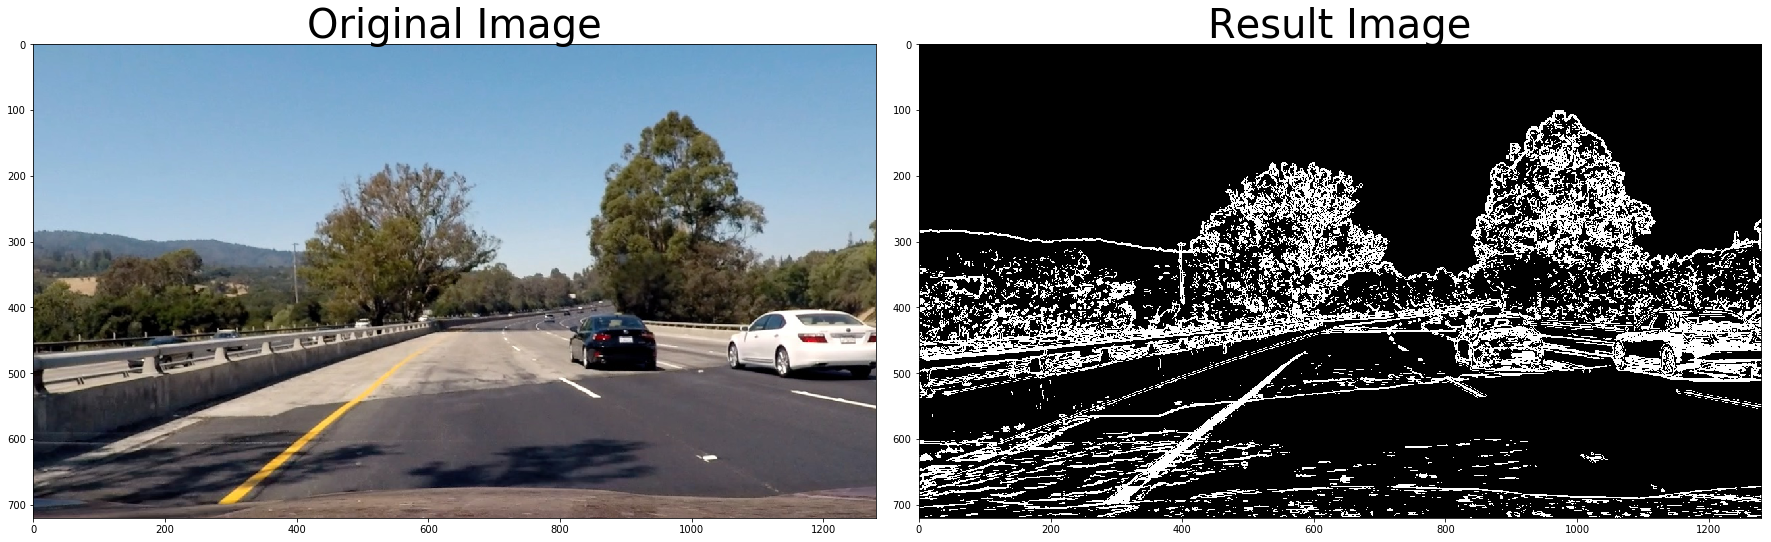

In [55]:
   
# define a pipeline for color and gradients transform to a input image.
def transformByColorGradients(img, s_thresh=(170, 255), sx_thresh=(20, 100), sobel_kernel=3):
    img = img.copy()
    # Sobel for gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #select S_channel
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
   
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

#test the color space and gradients function
print('----Test---:')
result_img = transformByColorGradients(undistorted)
plotOrignalResult(undistorted,result_img )



### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

---test---:


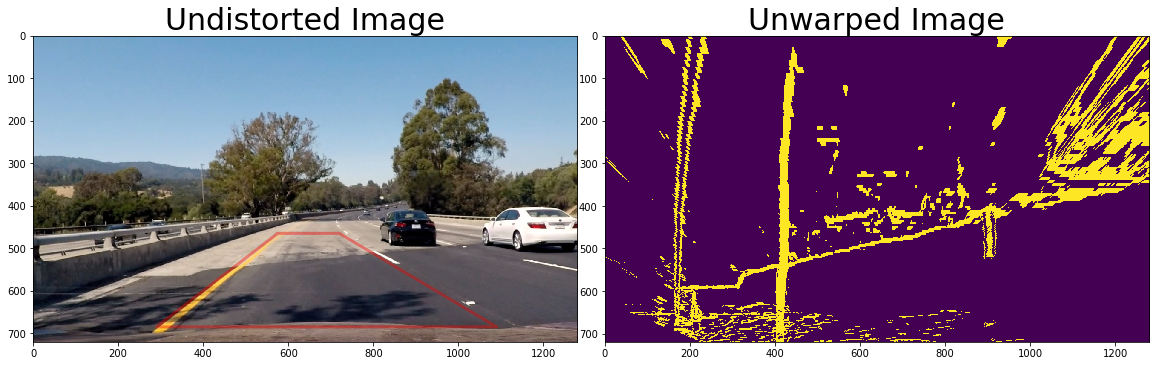

In [56]:

#define a perspective transform as a bird's eye to get the 

def unwarpToPerspective(img_undist, src, dst):
    #use the cv2.getPerspectiveTransform() to get M and then get the warped img
    height,width = img_undist.shape[:2]

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_warped = cv2.warpPerspective(img_undist, M, (width,height))
    return M, Minv, img_warped

def unwarpByHLS_S(img_warped, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    img_hls_unwarp = np.zeros_like(hls[:,:,2])
    img_hls_unwarp[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return img_hls_unwarp

#Plot the image for test...
def plotUnwarp(img_undist, img_warped, src, color ='#ee0000'):
    height,width = img_undist.shape[:2]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)

    ax1.imshow(img_undist)
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
    ax1.plot(x, y, color=color, alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_ylim([height,0])
    ax1.set_xlim([0,width])
    ax1.set_title('Undistorted Image', fontsize=30)

    ax2.imshow(img_warped)
    ax2.set_title('Unwarped Image', fontsize=30)


# test the perspective and unwarp bird's eys view
# define source and destination points for transform
print('---test---:')

height,width = result_img.shape[:2]

src = np.float32([(575,465),
                  (720,465), 
                  (290,685), 
                  (1090,685)])

dst = np.float32([(400,0),
                  (width-400,0),
                  (400,height),
                  (width-400,height)])

M, Minv, img_warped = unwarpToPerspective(result_img, src, dst)
#img_hls_unwarp = unwarpByHLS_S(img_warped)
plotUnwarp(undistorted,img_warped, src)



## 5. Detect lane pixels and fit to find the lane boundary.

-------Test-------


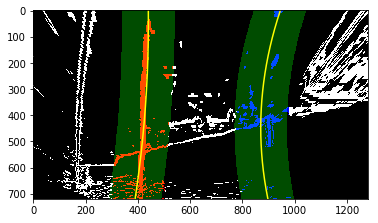

In [57]:
#input the warped imag to output the lane_pixels
def findLanePixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img

def fitPoly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

#fit the polynomial from the warped image
def fitPolynomial(binary_warped):
    # Find our lane pixels first
    ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = findLanePixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

###search_around_poly from the warped image and the left_fit/right_fit(output from find_lane_pixels)
def fitAroundPoly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fitPoly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result



###test the fit_polynomial
print('-------Test-------')
binary_warped = img_warped.copy()
#
#out_img = fitPolynomial(binary_warped)
# View your output
#plt.imshow(out_img)

# Run image 
ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = findLanePixels(binary_warped)

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

out_img = fitAroundPoly(binary_warped, left_fit, right_fit)
# View your output
plt.imshow(out_img)



## 6.Determine the curvature of the lane and vehicle position with respect to center.

In [58]:
#define the calculate the curvature   
def measureCurvatureReal(binary_warped, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    height = binary_warped.shape[0]
    ploty = np.linspace(0, height-1, height)# to cover same y-range as image
  
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Distance from center is image x midpoint - mean of left_fit and r_fit intercepts 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if left_fit is not None and right_fit is not None:
        car_position = binary_warped.shape[1]/2
    
        left_fit_x_int = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        right_fit_x_int = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
        
        lane_center_position = (right_fit_x_int + left_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist

print('-------Test-------')
binary_warped = img_warped.copy()
# Run image through the pipeline
ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = findLanePixels(binary_warped)
#
#left_fit = np.polyfit(lefty, leftx, 2)
#right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
#ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
#
#left_fitx, right_fitx, ploty = fitPoly(binary_warped.shape, leftx, lefty, rightx, righty)
#
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad, center_dist = measureCurvatureReal(binary_warped, leftx, lefty, rightx, righty)
print('left,right_curv:%f m,%f m,distance:%f m'%(left_curverad, right_curverad,center_dist))


-------Test-------
left,right_curv:33532.599413 m,489.279429 m,distance:-0.058217 m


## 6. Warp the detected lane boundaries back onto the original image.

-------TEST------


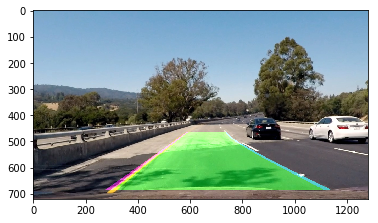

In [59]:
#plot the lane on the original image
def plotLane(original_img, warped_img, left_fit, right_fit, Minv):
    new_img = np.copy(original_img)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    height,width = warped_img.shape

    #Fit a second order polynomial to pixel positions in each fake lane line
    ploty = np.linspace(0, height-1, num=height)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (width, height)) 
    # Combine the result with the original image
    img_ploted = cv2.addWeighted(new_img, 1, new_warp, 0.5, 0)

    return img_ploted

#TEST
print('-------TEST------')

warped_img = img_warped.copy()

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

img_ploted = plotLane(undistorted, warped_img, left_fit, right_fit, Minv)

plt.imshow(img_ploted)


## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

-------TEST------


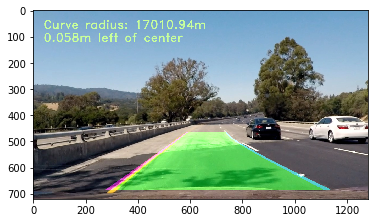

In [60]:
def plotData(ploted_img, curv_rad, center_dist):
    new_img = np.copy(ploted_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

#TEST
print('-------TEST------')
warped_img = img_warped.copy()

img_with_data = plotData(img_ploted, (left_curverad+right_curverad)/2, center_dist)

plt.imshow(img_with_data)

## 8. bukd a pipeline for a original image to img_with_data

---test---


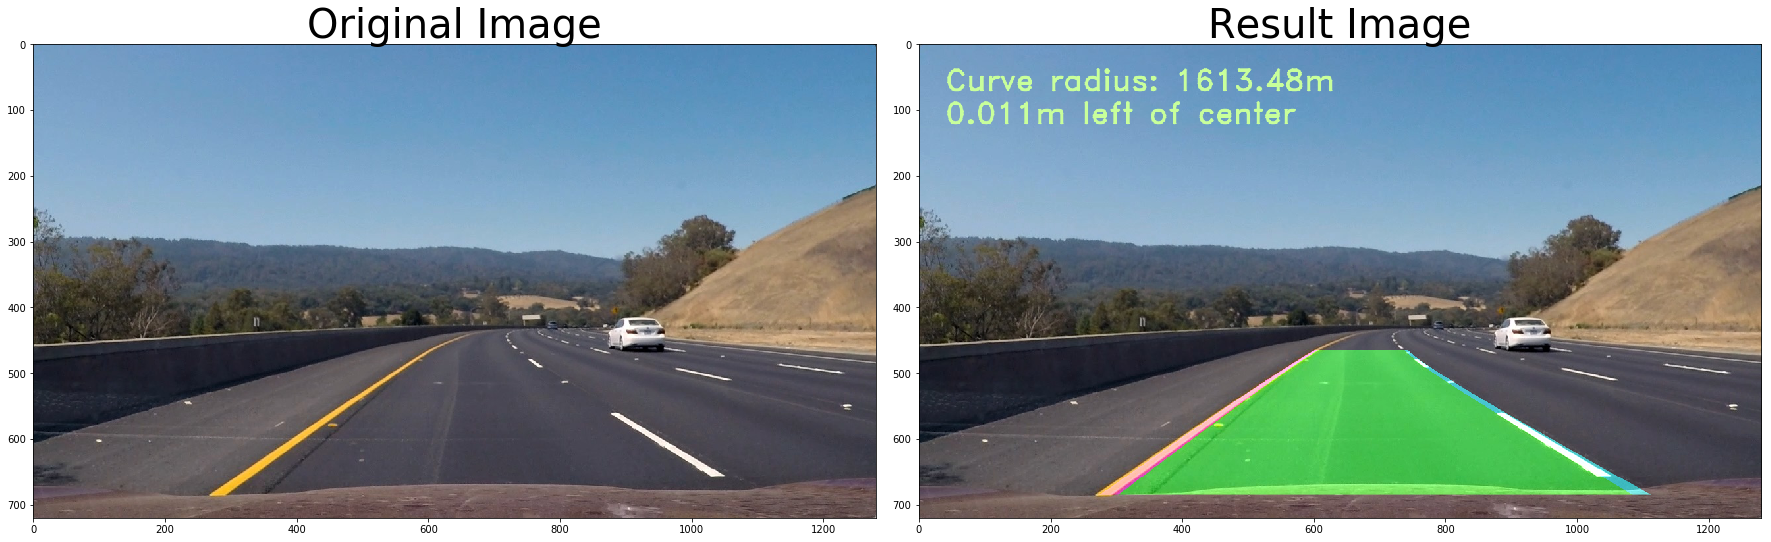

In [61]:
#global inputs:
# mtx, dist, mtx from camera distortion
# region [src, dst] for perspective transform
#
def pipeLine(img_original):
    new_img = np.copy(img_original)
    #cal
    #calUndistort(new_img, objpoints, imgpoints):
    #
    img_undistorted = cv2.undistort(new_img, mtx, dist, None, mtx)
    #
    img_transformed = transformByColorGradients(img_undistorted)
    #
    M, Minv, img_unwarped = unwarpToPerspective(img_transformed, src, dst)
    #
    ploty, leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = findLanePixels(img_unwarped)
    #
    left_curverad, right_curverad, center_dist = measureCurvatureReal(img_unwarped, leftx, lefty, rightx, righty)
    #
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    img_ploted = plotLane(new_img, warped_img, left_fit, right_fit, Minv)
    #
    img_with_data = plotData(img_ploted, (left_curverad+right_curverad)/2, center_dist)
    #

    return img_with_data


#Test
print('---test---')
img_original =mpimg.imread('test_images/test3.jpg')

img_with_data = pipeLine(img_original)

#plot the original image and undistorted image
plotOrignalResult(img_original, img_with_data) 


## 9. Appy on the video

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [63]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    result = pipeLine(image)
    # you should return the final output (image where lines are drawn on lanes)
    #print('result:',result)
    return result


In [65]:
## clip and handle the transformation
##
video_output = './output_videos/P2_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("./project_video.mp4")

clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video ./output_videos/P2_video_output.mp4
[MoviePy] Writing video ./output_videos/P2_video_output.mp4


100%|█████████▉| 1260/1261 [05:30<00:00,  3.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/P2_video_output.mp4 

CPU times: user 3min 6s, sys: 16.3 s, total: 3min 22s
Wall time: 5min 33s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
"""
     .format(video_output))